# Revisiting bit collisions in Morgan fingerprints with a larger dataset

I looked at the number of collisions in Morgan fingerprints in an [earlier post](http://rdkit.blogspot.ch/2014/02/colliding-bits.html). The topic came up again in discussions about the recent post on [Morgan fingerprint stats](http://rdkit.blogspot.ch/2016/02/morgan-fingerprint-bit-statistics.html), which used a much larger data set. 

Here we repeat earlier collision analysis, usting the larger dataset. I will look at fingerprints with different radii -- 1, 2, and 3 -- folded to a set of different sizes -- 1K, 2K, 4K, 8K.

TL;DR version: The conclusions match what we observed before, there are a fair number of collisions at fingerprint sizes below 4K. As expected, higher radii have more collisions. 

In [1]:
from rdkit import Chem,DataStructs
import time,random,gzip,pickle,copy
import numpy as np
from collections import defaultdict
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit import rdBase
%pylab inline

print(rdBase.rdkitVersion)
import time
print(time.asctime())

/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)

Populating the interactive namespace from numpy and matplotlib
2016.03.1.dev1
Sat Feb  6 08:29:19 2016


pylab import has clobbered these variables: ['copy', 'random']
`%matplotlib` prevents importing * from pylab and numpy


For test data I'll use the same 16 million ZINC compounds I used in the [bit statistics post](http://rdkit.blogspot.ch/2016/02/morgan-fingerprint-bit-statistics.html).

In [2]:
filen='/scratch/RDKit_git/Data/Zinc/zinc_all_clean.pkl.gz'

Loop over the molecules and build fingerprints of multiple radii and folded lengths.

In [25]:
import copy
history={} # we will use this to see how quickly the results converge
counts=defaultdict(lambda:defaultdict(int))
t1 = time.time()
with gzip.open(filen,'rb') as inf:
    i = 0
    while 1:
        try:
            m,nm = pickle.load(inf)
        except EOFError:
            break
        if not m: continue
        i+=1
        for v in 1,2,3:
            onbits=len(rdmd.GetMorganFingerprint(m,v).GetNonzeroElements())
            counts[(v,-1)][onbits]+=1
            for l in 1024,2048,4096,8192:
                dbits = onbits-rdmd.GetMorganFingerprintAsBitVect(m,v,l).GetNumOnBits()
                counts[(v,l)][dbits]+=1
        if not i%20000:
            t2 = time.time()
            print("Done %d in %.2f sec"%(i,t2-t1))
        if not i%100000:
            history[i] = copy.deepcopy(counts)

Done 20000 in 14.47 sec
Done 40000 in 29.38 sec
Done 60000 in 43.27 sec
Done 80000 in 58.64 sec
Done 100000 in 73.00 sec
Done 120000 in 87.05 sec
Done 140000 in 101.53 sec
Done 160000 in 116.54 sec
Done 180000 in 132.68 sec
Done 200000 in 153.34 sec
Done 220000 in 173.43 sec
Done 240000 in 193.01 sec
Done 260000 in 214.54 sec
Done 280000 in 235.56 sec
Done 300000 in 254.19 sec
Done 320000 in 274.25 sec
Done 340000 in 294.64 sec
Done 360000 in 315.28 sec
Done 380000 in 336.34 sec
Done 400000 in 354.57 sec
Done 420000 in 370.60 sec
Done 440000 in 383.79 sec
Done 460000 in 403.03 sec
Done 480000 in 421.93 sec
Done 500000 in 442.54 sec
Done 520000 in 464.06 sec
Done 540000 in 484.28 sec
Done 560000 in 505.65 sec
Done 580000 in 520.50 sec
Done 600000 in 537.79 sec
Done 620000 in 558.37 sec
Done 640000 in 578.28 sec
Done 660000 in 596.63 sec
Done 680000 in 616.67 sec
Done 700000 in 637.04 sec
Done 720000 in 660.30 sec
Done 740000 in 677.56 sec
Done 760000 in 697.47 sec
Done 780000 in 717.60 

In [26]:
pickle.dump(dict(counts),gzip.open('../data/fp_collision_counts.pkl.gz','wb+'))

In [27]:
for k,d in history.items():
    history[k] = dict(d)
pickle.dump(dict(history),gzip.open('../data/fp_collision_counts.history.pkl.gz','wb+'))

Now plot histograms of the numbers of collisions along with the distributions of the number of bits set in the non-folded FPs

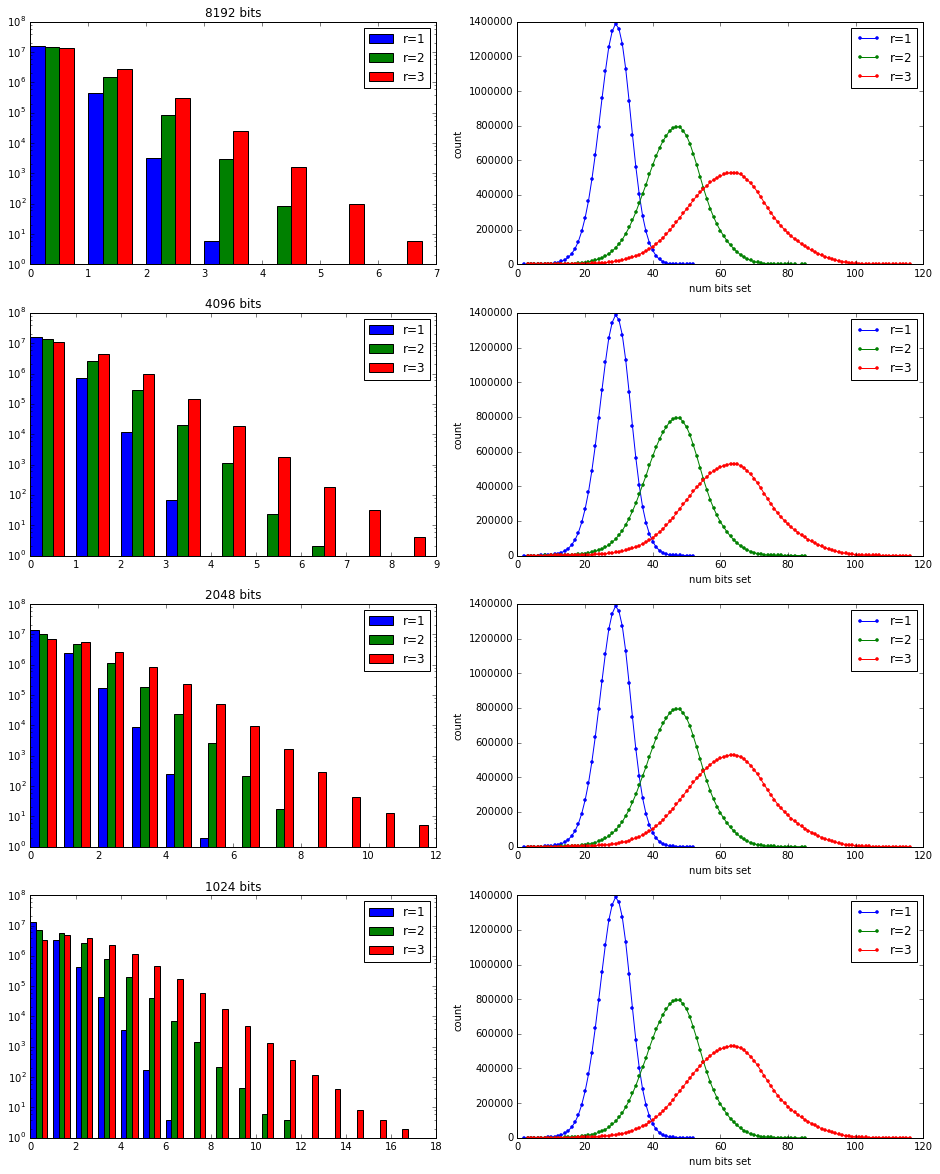

In [58]:
figure(figsize=(16,20))

pidx=1
#----------------------------
for nbits in (8192,4096,2048,1024):
    subplot(4,2,pidx)
    pidx+=1
    maxCollisions = max(counts[3,nbits].keys())+1
    d1=np.zeros(maxCollisions,np.int)
    for k,v in counts[1,nbits].items():
        d1[k]=v
    d2=np.zeros(maxCollisions,np.int)
    for k,v in counts[2,nbits].items():
        d2[k]=v
    d3=np.zeros(maxCollisions,np.int)
    for k,v in counts[3,nbits].items():
        d3[k]=v
    barWidth=.25
    locs = np.array(range(maxCollisions))

    bar(locs,d1,barWidth,color='b',label="r=1")
    bar(locs+barWidth,d2,barWidth,color='g',label="r=2")
    bar(locs+2*barWidth,d3,barWidth,color='r',label="r=3")
    
    #_=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=yscale("log")
    _=legend()

    subplot(4,2,pidx)
    pidx+=1
    plot([x for x,y in counts[1,-1].items()],[y for x,y in counts[1,-1].items()],'.b-',label=
        "r=1")
    plot([x for x,y in counts[2,-1].items()],[y for x,y in counts[2,-1].items()],'.g-',label=
        "r=2")
    plot([x for x,y in counts[3,-1].items()],[y for x,y in counts[3,-1].items()],'.r-',label=
        "r=3")
    _=xlabel("num bits set")
    _=ylabel("count")
    _=legend()
    
    

So, there are definitely some collisions. But not a huge number.

It's tempting to look at the effect on similarity, but looking at random pairs basically implies looking at differences in the noise. I'm not sure that really helps, so I won't do it here.

In [ ]:
figure(figsize=(16,20))

pidx=1
#----------------------------
for nbits in (8192,4096,2048,1024):
    subplot(4,2,pidx)
    pidx+=1
    maxCollisions = max(counts[3,nbits].keys())+1
    d1=np.zeros(maxCollisions,np.int)
    for k,v in counts[1,nbits].items():
        d1[k]=v
    d2=np.zeros(maxCollisions,np.int)
    for k,v in counts[2,nbits].items():
        d2[k]=v
    d3=np.zeros(maxCollisions,np.int)
    for k,v in counts[3,nbits].items():
        d3[k]=v
    barWidth=.25
    locs = np.array(range(maxCollisions))

    bar(locs,d1,barWidth,color='b',label="r=1")
    bar(locs+barWidth,d2,barWidth,color='g',label="r=2")
    bar(locs+2*barWidth,d3,barWidth,color='r',label="r=3")
    
    #_=hist((d1,d2,d3),bins=20,log=True,label=("r=1","r=2","r=3"))
    title('%d bits'%nbits)
    _=yscale("log")
    _=legend()

    subplot(4,2,pidx)
    pidx+=1
    plot([x for x,y in counts[1,-1].items()],[y for x,y in counts[1,-1].items()],'.b-',label=
        "r=1")
    plot([x for x,y in counts[2,-1].items()],[y for x,y in counts[2,-1].items()],'.g-',label=
        "r=2")
    plot([x for x,y in counts[3,-1].items()],[y for x,y in counts[3,-1].items()],'.r-',label=
        "r=3")
    _=xlabel("num bits set")
    _=ylabel("count")
    _=legend()
    
    